In [ ]:
from datetime import datetime
import itertools as it
import os
from typing import Dict, Tuple

import numpy as np
import torch
from torch import nn
from torchvision import models as tvmodels
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_model = torch.cuda.get_device_name(torch.cuda.current_device())
print(f'GPU: {device_model}')

GPU: NVIDIA GeForce GTX 1080 Ti


In [ ]:
def set_seed(seed):
    """
    Function for setting the seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def warmup(model, dummy_in, warmup_steps=600, **_):
    dummy_in = dummy_in[None, :]
    for _ in range(warmup_steps):
        with torch.no_grad():
            model(dummy_in)


# Questions:
#- should I account for preprocessing time? not doing it rn
#- should I warmup every model? not really
def eval_model(model, dummy_inputs, use_grad=False, **kwargs):
    model.eval()
    warmup(model, dummy_inputs[0], **kwargs)

    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    records = np.zeros(len(dummy_inputs) - 1)

    with torch.set_grad_enabled(use_grad):
        for rep, dummy_input in enumerate(dummy_inputs[1:]):
            start_event.record()
            model(dummy_input[None, :])
            end_event.record()
            torch.cuda.synchronize()
            records[rep] = start_event.elapsed_time(end_event)

    return records


def num_params(model):
    return sum(int(np.prod(p.shape)) for p in model.parameters())


def now() -> str:
    return datetime.now().strftime("%H:%M:%S")


def eval_one_model(model_builder, weights, accuracy, dummy_inputs, **kwargs):
    model_name = model_builder.__name__
    print(f"{now()} Evaluating {model_name}")
    weights = weights.DEFAULT
    model = model_builder(weights=weights).to(device)
    times = eval_model(model, weights.transforms()(dummy_inputs), **kwargs)
    return {
        "name": model_name,
        "acc@1": accuracy,
        "num_params": num_params(model),
        "inference_mean": times.mean(),
    }


def gen_synth_inputs(n=300) -> torch.Tensor:
    imagenet_shape = (n, 3, 224, 224)
    return torch.rand(*imagenet_shape)


# unit of measure: MB
def get_gpu_mem() -> int:
    return torch.cuda.memory_allocated() / (1024**2)


def clear_gpu_cache():
    torch.cuda.empty_cache()


def model_memory_usage(model_maker, input_, use_grad=False):
    start = get_gpu_mem()
    model = model_maker()
    model.eval()
    with torch.set_grad_enabled(use_grad):
        res = model(input_)
    end = get_gpu_mem()
    diff = end - start
    print(f"After evaluation with use_grad: {use_grad} {end} diff {diff}")
    return diff


def compare_same_model(model_builder, weights, dummy_input):
    model_name = model_builder.__name__
    print("-" * 15)
    print(f"{now()} Model: {model_name}, GPU usage: {get_gpu_mem()}")

    clear_gpu_cache()
    weights = weights.DEFAULT
    make_model = lambda: model_builder(weights=weights).to(device)
    dummy_input = weights.transforms()(dummy_input)
    print(f"Preproc input, GPU: {get_gpu_mem()}")
    mem_nograd = model_memory_usage(make_model, dummy_input)
    print(f"GPU usage after NO GRAD: {get_gpu_mem()}")

    clear_gpu_cache()  # previous experiments show this is not needed actually
    mem_grad = model_memory_usage(make_model, dummy_input, use_grad=True)
    print(f"GPU usage after GRAD: {get_gpu_mem()}")
    return [
        {"name": model_name, "GPU_memory": mem_nograd, "grad": False},
        {"name": model_name, "GPU_memory": mem_grad, "grad": True},
    ]


def show_models_comparison(
    df: pd.DataFrame,
    xvar: str,
    yvar: str,
    xlab: str,
    ylab: str,
    title: str,
    text_coords: Dict[str, Tuple[Tuple[float, float], str, str]] = None,
    yscale: str=None,
    fontsize=15,
    figsize=(10, 10),
    verbose=False
) -> Tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df, x=xvar, y=yvar, hue="name", ax=ax, legend=False, s=70)
    ax.set_xlabel(xlab, fontsize=fontsize)
    ax.set_ylabel(ylab, fontsize=fontsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_title(title, fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    if yscale:
        ax.set_yscale(yscale)
    ax.grid()
    text_coords = text_coords or {}
    for i, (_, row) in enumerate(df.iterrows()):
        coords, align_h, align_v = text_coords.get(row["name"], ((0.0, 12.0), "center", "baseline"))
        if verbose:
            print(row["name"], coords, align_h, align_v)
        ax.annotate(
            row["name"],
            xy=(row[xvar], row[yvar]),
            xytext=coords,
            horizontalalignment=align_h,
            verticalalignment=align_v,
            textcoords="offset points",
            fontsize=fontsize,
        )
    return fig, ax


def barplot_models_comparison(
    df: pd.DataFrame,
    xvar: str,
    yvar: str,
    xlab: str,
    ylab: str,
    title: str,
    yscale: str=None,
    fontsize=15,
    figsize=(10, 10),
) -> Tuple[plt.Figure, plt.Axes]:
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=df, x=xvar, y=yvar, hue="grad", ax=ax)
    if yscale:
        ax.set_yscale(yscale)
    ax.set_xlabel(xlab, fontsize=fontsize)
    ax.set_ylabel(ylab, fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.xaxis.set_tick_params(labelsize=fontsize)
    ax.yaxis.set_tick_params(labelsize=fontsize)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    plt.setp(ax.get_legend().get_title(), fontsize=str(fontsize)) 
    plt.setp(ax.get_legend().get_texts(), fontsize='13') 
    ax.grid()
    return fig, ax

In [ ]:
sns.set(style="ticks")

assets_dir = os.path.join(os.getcwd(), "assets")
os.makedirs(assets_dir, exist_ok=True)
print(f"All images saved to {assets_dir}")

All images saved to /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets


In [ ]:
models = [
    tvmodels.vgg11,
    tvmodels.vgg11_bn,
    tvmodels.resnet18,
    tvmodels.resnet34,
    tvmodels.densenet121,
    tvmodels.mobilenet_v3_small,
]

pretrained_weights = [
    tvmodels.VGG11_Weights,
    tvmodels.VGG11_BN_Weights,
    tvmodels.ResNet18_Weights,
    tvmodels.ResNet34_Weights,
    tvmodels.DenseNet121_Weights,
    tvmodels.MobileNet_V3_Small_Weights,
]

accuracies = np.array([69.02, 70.37, 69.758, 73.314, 74.434, 67.668])
accuracies /= 100.0

In [ ]:
set_seed(42)

synth_inputs = gen_synth_inputs(n=301).to(device)
print(f"Synthetic inputs: {synth_inputs.shape} {synth_inputs.dtype}")

Synthetic inputs: torch.Size([301, 3, 224, 224]) torch.float32


In [ ]:
# NOTE I think warmup is to be done once, however do it every time here to have
# standardized comparisons
models_times = [
    eval_one_model(model_, weights, accuracy, synth_inputs, warmup_steps=warmup_steps)
    for model_, weights, accuracy, warmup_steps in zip(
        models, pretrained_weights, accuracies, [600] * len(models)
    )
]

15:23:29 Evaluating vgg11
15:23:38 Evaluating vgg11_bn
15:23:46 Evaluating resnet18
15:23:50 Evaluating resnet34
15:23:58 Evaluating densenet121
15:24:26 Evaluating mobilenet_v3_small


In [ ]:
models_times_df = pd.DataFrame(models_times)
models_times_df["num_params"] /= 1e6
models_times_df

,name,acc@1,num_params,inference_mean
0,vgg11,0.69020,132.863336,4.283179
1,vgg11_bn,0.70370,132.868840,4.518322
2,resnet18,0.69758,11.689512,4.697892
3,resnet34,0.73314,21.797672,8.132064
4,densenet121,0.74434,7.978856,30.644260
5,mobilenet_v3_small,0.67668,2.542856,9.509375


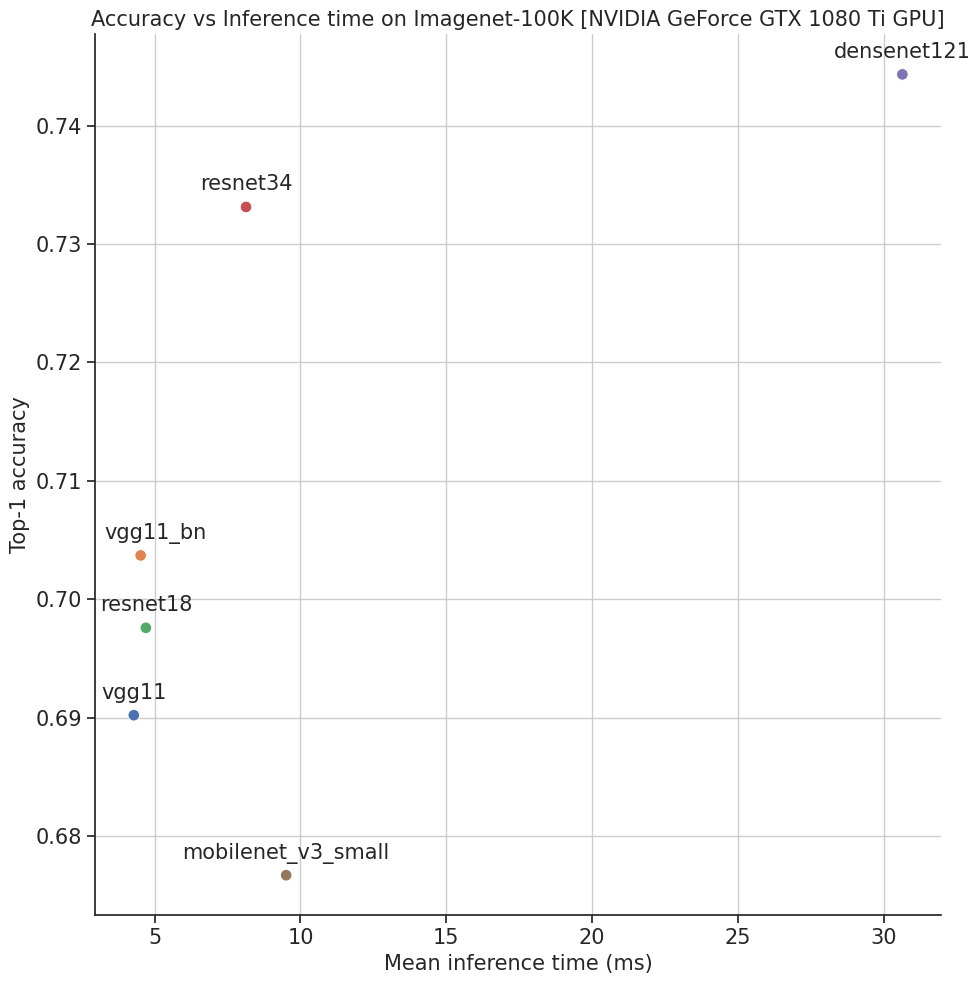

In [ ]:
fig, _ = show_models_comparison(
    models_times_df,
    "inference_mean",
    "acc@1",
    "Mean inference time (ms)",
    "Top-1 accuracy",
    f"Accuracy vs Inference time on Imagenet-100K [{device_model} GPU]",
    text_coords={"vgg11_bn": ((11.0, 12.0), "center", "baseline")},
)
plt.tight_layout()

In [ ]:
fname = os.path.join(assets_dir, f"accuracy_infer_speed_{device_model}.png")
fname = fname.replace(" ", "_")
fig.savefig(fname)
print(f"Saved image {fname}")

Saved image /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets/accuracy_infer_speed_NVIDIA_GeForce_GTX_1080_Ti.png


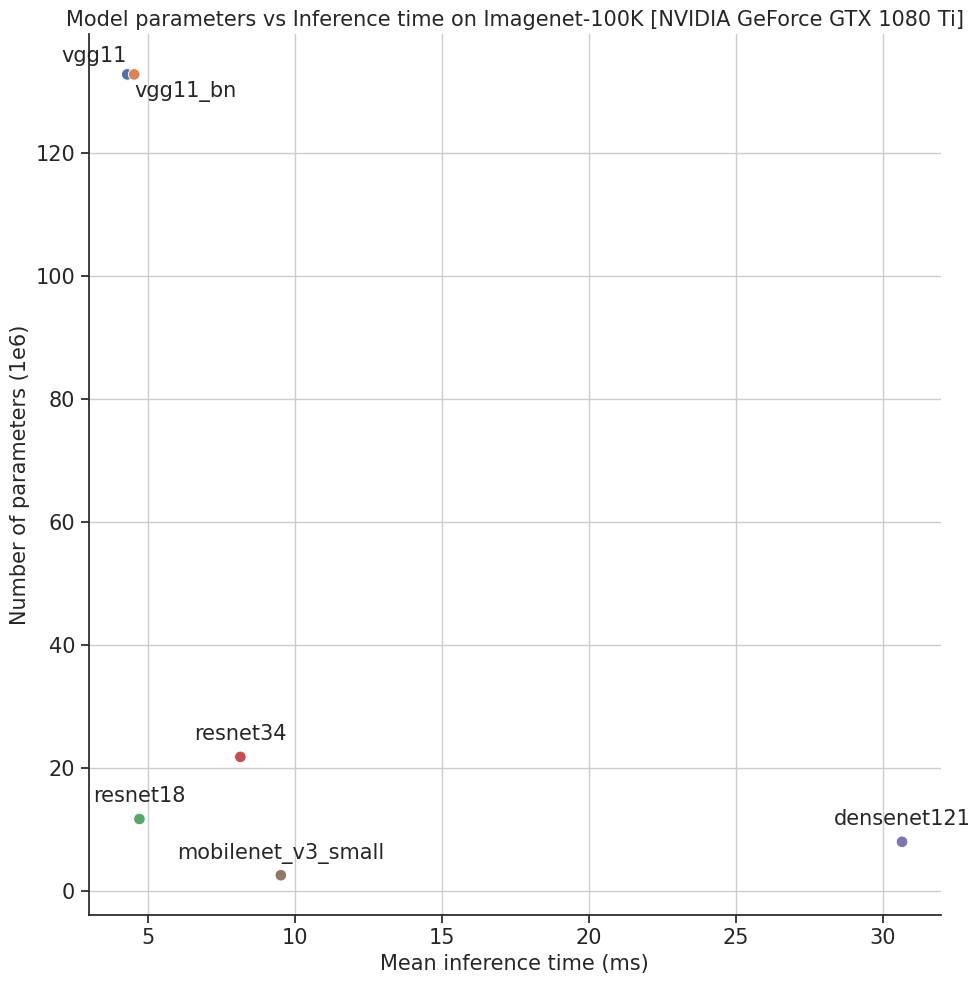

In [ ]:
fig, _ = show_models_comparison(
    models_times_df,
    "inference_mean",
    "num_params",
    "Mean inference time (ms)",
    "Number of parameters (1e6)",
    f"Model parameters vs Inference time on Imagenet-100K [{device_model}]",
    text_coords={
        #"resnet18": ((11.0, 13.0), "center", "baseline"),
        "vgg11": ((0.0, 9.0), "right", "baseline"),
        "vgg11_bn": ((0.0, -16.0), "left", "baseline"),
    },
    #yscale="log"
)
plt.tight_layout()

In [ ]:
fname = os.path.join(assets_dir, f"numparams_infer_speed_{device_model}.png")
fname = fname.replace(" ", "_")
fig.savefig(fname)
print(f"Saved image {fname}")

Saved image /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets/numparams_infer_speed_NVIDIA_GeForce_GTX_1080_Ti.png


In [ ]:
models_times_grad = [
    eval_one_model(
        model_, weights, accuracy, synth_inputs, warmup_steps=warmup_steps, use_grad=True
    )
    for model_, weights, accuracy, warmup_steps in zip(
        models, pretrained_weights, accuracies, [600] * len(models)
    )
]

15:33:48 Evaluating vgg11
15:33:54 Evaluating vgg11_bn
15:34:00 Evaluating resnet18
15:34:05 Evaluating resnet34
15:34:13 Evaluating densenet121
15:34:43 Evaluating mobilenet_v3_small


In [ ]:
times_grad_df = pd.DataFrame(models_times_grad)
times_grad_df["grad"] = True
times_grad_df

,name,acc@1,num_params,inference_mean,grad
0,vgg11,0.69020,132863336,4.469153,True
1,vgg11_bn,0.70370,132868840,4.792513,True
2,resnet18,0.69758,11689512,5.742750,True
3,resnet34,0.73314,21797672,9.897094,True
4,densenet121,0.74434,7978856,38.764781,True
5,mobilenet_v3_small,0.67668,2542856,12.582482,True


In [ ]:
models_times_df["grad"] = False
merged_df = pd.concat([models_times_df, times_grad_df])

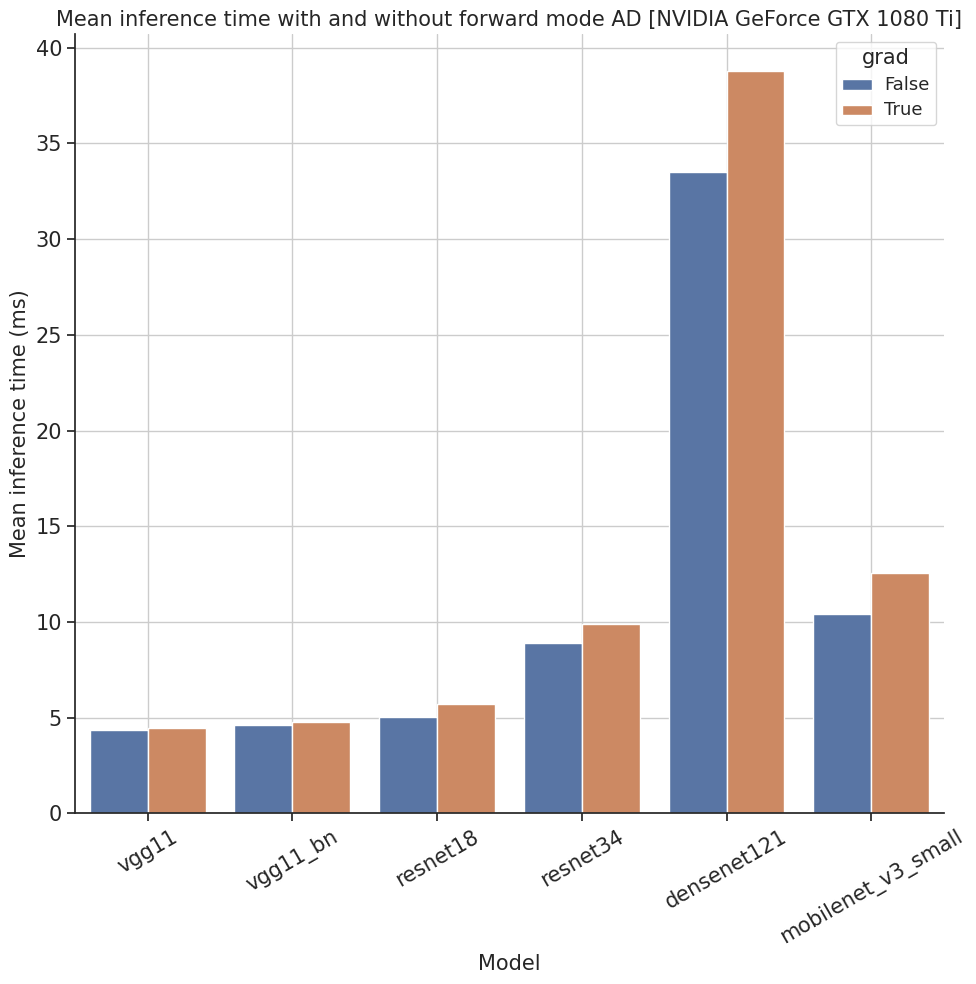

In [ ]:
fig, _ = barplot_models_comparison(
    merged_df,
    "name",
    "inference_mean",
    "Model",
    "Mean inference time (ms)",
    f"Mean inference time with and without forward mode AD [{device_model}]",
)
plt.tight_layout()

In [ ]:
fname = os.path.join(assets_dir, f"infer_speed_grad_comparison_{device_model}.png")
fname = fname.replace(" ", "_")
fig.savefig(fname)
print(f"Saved image {fname}")

Saved image /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets/infer_speed_grad_comparison_NVIDIA_GeForce_GTX_1080_Ti.png


In [ ]:
print(f"Very start: {get_gpu_mem()}")

dummy_input = torch.rand(64, 3, 224, 224).to(device)
measures = []

init_gpu_mem = get_gpu_mem()
print(f"Input on GPU, memory: {init_gpu_mem}")

Very start: 172.83984375
Input on GPU, memory: 209.58984375


In [ ]:
memory_measures = [compare_same_model(model_, w, dummy_input) for model_, w in zip(models, pretrained_weights)]

---------------
15:34:52 Model: vgg11, GPU usage: 209.58984375
Preproc input, GPU: 246.33984375
After evaluation with use_grad: False 753.453125 diff 507.11328125
GPU usage after NO GRAD: 246.33984375
After evaluation with use_grad: True 3697.828125 diff 3451.48828125
GPU usage after GRAD: 246.33984375
---------------
15:34:56 Model: vgg11_bn, GPU usage: 209.58984375
Preproc input, GPU: 246.33984375
After evaluation with use_grad: False 753.5 diff 507.16015625
GPU usage after NO GRAD: 246.33984375
After evaluation with use_grad: True 5510.875 diff 5264.53515625
GPU usage after GRAD: 246.33984375
---------------
15:35:01 Model: resnet18, GPU usage: 209.58984375
Preproc input, GPU: 246.33984375
After evaluation with use_grad: False 291.2626953125 diff 44.9228515625
GPU usage after NO GRAD: 246.33984375
After evaluation with use_grad: True 1618.1845703125 diff 1371.8447265625
GPU usage after GRAD: 246.33984375
---------------
15:35:02 Model: resnet34, GPU usage: 209.58984375
Preproc input

In [ ]:
memory_df = pd.DataFrame(it.chain(*memory_measures))
memory_df

,name,GPU_memory,grad
0,vgg11,507.113281,False
1,vgg11,3451.488281,True
2,vgg11_bn,507.160156,False
3,vgg11_bn,5264.535156,True
4,resnet18,44.922852,False
5,resnet18,1371.844727,True
6,resnet34,84.067383,False
7,resnet34,2026.442383,True
8,densenet121,31.103027,False
9,densenet121,7988.892090,True


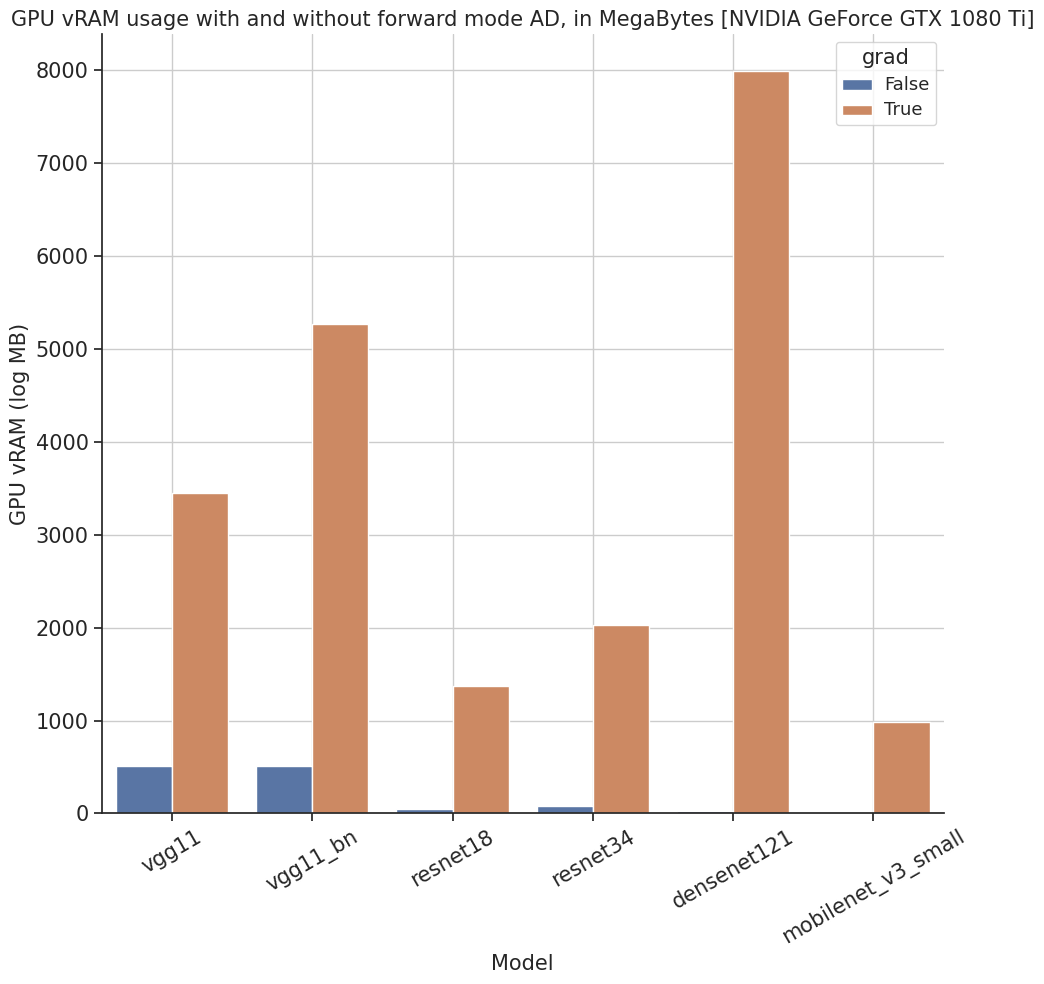

In [ ]:
fig, _ = barplot_models_comparison(
    memory_df,
    "name",
    "GPU_memory",
    "Model",
    "GPU vRAM (MB)",
    f"GPU vRAM usage with and without forward mode AD, in MegaBytes [{device_model}]",
    #yscale="log"
)
plt.tight_layout()

In [ ]:
fname = os.path.join(assets_dir, f"gpu_vram_grad_comparison_{device_model}.png")
fname = fname.replace(" ", "_")
fig.savefig(fname)
print(f"Saved image {fname}")

Saved image /home/lcur0339/uvadlc_practicals_2022/assignment2/part1/assets/gpu_vram_grad_comparison_NVIDIA_GeForce_GTX_1080_Ti.png
